In [1]:
## This notebook will be used to generate figures for the K562 ATRi nominating screen, specifically a volcano plot
##for rho values in the screen to show metrics for inclusion of genes in the ATRi GI maps

## Plots generated using this notebook are used in Figure 1C and 1D

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import gseapy as gp
import seaborn as sns
from matplotlib.colors import Normalize

In [2]:
## import data

## import and define the file "nominating_screen_phenotypes.xlsx" from:
## https://ucsf.box.com/s/nuwov4kgb55mqfrr7j5a216ot78f4uxn 
## as "screen_data", set index_col = 0 

screen_data = pd.read_excel('/Users/benh/Desktop/nominating_screen_phenotypes.xlsx',index_col = 0)

In [3]:
## isolate the columns that include the replicate average rho and associated pvalues
rho_df = screen_data.iloc[2:,[26,27]]
rho_df.columns = ['pval','rho']
rho_df = rho_df.dropna()
rho_df['-log10pval'] = [-np.log10(item) for item in rho_df['pval']]

In [4]:
## define a list of genes that pass the threshold: |rho|>0.2 and pval<0.02
thresh_pass = [i for i in range(len(rho_df.index)) if rho_df.iloc[i,0]<0.02 and abs(rho_df.iloc[i,1])>0.2]


In [5]:
## define the list of negative controls
neg_list = []
for item in screen_data.iloc[3:,:].index:
    if type(item) == str:
        if item.split('_')[0] == 'pseudo':
            neg_list.append(item)


In [6]:
## highlight some positive control genes

posControl = ['HUS1','RAD9A','RAD1','CDC25A','RAD17','ETAA1']


(-1.25, 1.25)

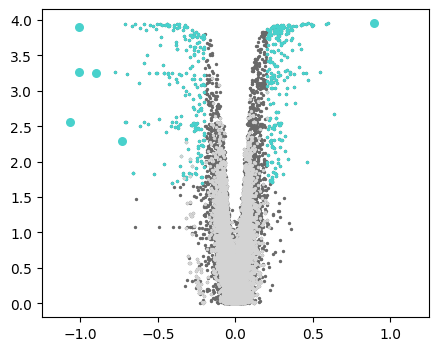

In [7]:
## Plot all rho data, as well as list subsets defined in the previous cells

plt.figure(figsize=(5,4))
plt.scatter(rho_df['rho'],rho_df['-log10pval'], s = 2, c='dimgray')
plt.scatter(rho_df.iloc[thresh_pass,1],rho_df.iloc[thresh_pass,2], s= 2, c='mediumturquoise')
plt.scatter(rho_df.loc[neg_list,'rho'],rho_df.loc[neg_list,'-log10pval'], s=2, c='lightgray')


## Plot positive controls using larger dots
plt.scatter(rho_df.loc[posControl,'rho'],rho_df.loc[posControl,'-log10pval'],color = 'mediumturquoise',s=30)

#plt.xlabel('Normalized log2 fold enrichment')
#plt.ylabel('-log10 Mann-Whitney p-value')
plt.xlim(-1.25,1.25)


#plt.savefig('/Users/benh/Desktop/pilotThreshold.png',dpi=300)

In [ ]:
## run GO term enrichment analysis on the thresh_pass hit list
gene_list = list(rho_df.iloc[thresh_pass,:].index)

## Define the GO term collections we'll be 
gene_sets = ['GO_Biological_Process_2023','GO_Cellular_Component_2023','GO_Molecular_Function_2023']

## Create an dataframe for the output values from the gsea
out_df = pd.DataFrame(index = range(10),columns = ['Gene_set','Term','Overlap','P-value',
                                                   'Adjusted P-value','Old P-value','Old Adjusted P-value',
                                                   'Odds-Ratio','Combined Score','Genes'])

## iterate through ten cycles of GO term enrichment. Each cycle we'll take the most significantly enriched GO term
## and then remove genes associated with that GO term from the test list for the next cycle
for i in range(10):
    test = gp.enrichr(gene_list,gene_sets =gene_sets,organism='human',outdir = None)
    gl_remove = test.results.loc[0,'Genes'].split(';')
    gene_list = [item for item in gene_list if item not in gl_remove]
    for cat in test.results.loc[0,:]:
        for z,col in enumerate(out_df.columns):
            out_df.iloc[i,z] = test.results.iloc[0,z]
    print(str(i+1)+' tests run!')

In [44]:
## fill lists with sizes (number of genes), pvals, and labels of each of the 10 top GO terms from the out df
## also, transform pval to -log

sizes = []
adj_pvals = []
terms = []
for i in out_df.index:
    sizes.append(len(out_df.loc[i,'Genes'].split(';')))
    adj_pvals.append(-np.log10(out_df.loc[i,'Adjusted P-value']))
    terms.append(out_df.loc[i,'Term'])

##define a seaborn colormap to map pvals to
new_palette = sns.light_palette((210, 70, 80), input="husl", as_cmap=True)
norm = Normalize(vmin=0, vmax=5)
    
cols = []
for val in adj_pvals:
    cols.append(new_palette(norm(val)))

In [51]:
adj_pvals

[35.38282427937018,
 28.623764715856375,
 15.979455888859777,
 7.337198267412681,
 7.221566477100223,
 5.489837512664597,
 3.314465732943859,
 2.703647506759571,
 1.9476309278105994,
 1.839038074404347]

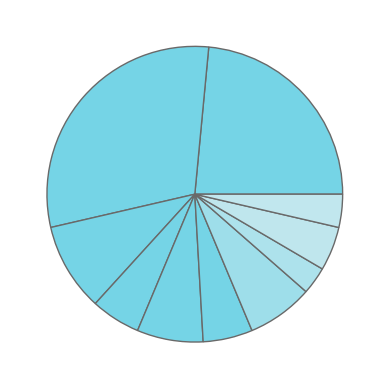

In [49]:
## plot a pie chart of the ten GO terms 

plt.pie(sizes,colors = cols,
       wedgeprops={'edgecolor': 'dimgray'},
       #labels = False,
       rotatelabels=True,
       )
#plt.savefig('/Users/benh/Desktop/go_pie.png',dpi=300)
plt.show()